In [1]:
import itertools
import random
import json

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from scipy.special import softmax

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import simulations
import visualizations

# Defining Worlds and Actions 

In [4]:
test_colors = ['blue', 'green']
test_shapes = ['circle', 'square']
test_features = test_colors + test_shapes
test_values = [-1, 1]

test_action_context = simulations.generate_context_from_actions([("green", "circle"), ("blue", "circle"), ("green", "square")])

test_worlds = simulations.generate_worlds_from_feature_values(test_features, test_values)

# Literal Listener: Beliefs and Actions

### Belief Updates
Given a message $u$ which consists of a feature-value tuple $(\phi, \mathbb{R})$, condition worlds $w$ and return only those with are literally consistent with that utterance. This implements Eq. 3 / 11 from the paper:


\begin{equation}
    P_L(w \mid u) \propto \delta_{[ u ] (w)} P(w)
\end{equation} 

$$
p_L(w_L \mid u) = p_L(w_L \mid u_{\mathbb{1}_K} =  u_{\mathbb{R}})
$$

In [5]:
from listeners import StatelessLiteralListener

# Condition on a message
test_message = ('green', 1)
test_beliefs = StatelessLiteralListener.condition_worlds_on_message(test_worlds, test_message)

print("Before conditioning, {} possible worlds.".format(len(test_worlds)))
print("After conditioning, {} possible worlds.".format(len(test_beliefs)))
test_beliefs.head()

Before conditioning, 16 possible worlds.
After conditioning, 8 possible worlds.


,blue,green,circle,square,probability
4,-1,1,-1,-1,0.125
5,-1,1,-1,1,0.125
6,-1,1,1,-1,0.125
7,-1,1,1,1,0.125
12,1,1,-1,-1,0.125


### Listener Rewards

Given an action dataframe $A$ and beliefs about rewards $w$, assign rewards to all actions. 

This implements Eq. 11 from the paper:

$$
R(a, w) = w^\top\phi(a)
$$

It can be called with either a Pandas `Series` or `DataFrame`. If `DataFrame`, will marginalize over beliefs and return expected rewards.

In [6]:
rewards = pd.Series({"blue": -1, "green": 1, "circle": 1, "square": -1})
print(test_action_context.index)
StatelessLiteralListener.estimate_rewards(rewards, test_action_context)

Index(['green circle', 'blue circle', 'green square'], dtype='object')


array([2., 0., 0.])

In [7]:
# With a belief dataframe from before:
print(test_action_context.index)
StatelessLiteralListener.estimate_rewards(test_beliefs, test_action_context)

Index(['green circle', 'blue circle', 'green square'], dtype='object')


array([1., 0., 1.])

### Listener Policy
Given the listener's belief distribution and available actions, calculate their distribution over possible actions.

This implements Eq. 4 and 5 from the paper, 


\begin{equation}
    R_L(a, u) = \sum_{W}  R(a, w) P_L(w \mid u)
\end{equation}

$$
    \pi_L(a \mid u, A) = \frac{
    \exp\{\beta_L \cdot R_L(a, u)\}
}{
\sum_{a' \in A} \exp\{\beta_L \cdot R_L(a', u) \}
}
$$

In [8]:
literal_listener = StatelessLiteralListener(3, test_features, test_worlds)

test_message = ('green', 1)
literal_listener.action_policy(test_message, test_action_context)

,green,circle,blue,square,listener_reward,listener_choice_prob
green circle,1.0,1.0,0.0,0.0,1.0,0.487856
blue circle,0.0,1.0,1.0,0.0,0.0,0.024289
green square,1.0,0.0,0.0,1.0,1.0,0.487856


In [9]:
test_message = ('blue', 1)
literal_listener.action_policy(test_message, test_action_context)

,green,circle,blue,square,listener_reward,listener_choice_prob
green circle,1.0,1.0,0.0,0.0,0.0,0.045279
blue circle,0.0,1.0,1.0,0.0,1.0,0.909443
green square,1.0,0.0,0.0,1.0,0.0,0.045279


# Speaker Models

All of the speaker models implement `BaseSpeaker`, and take an utterance and action context to calculate a utility for that utterance.

These utilities are used to choose utterances.

### Belief-Oriented Speaker
The belief-oriented speaker optimizes the probability of a literal listener inferring the true world state.

From the paper, this is Eqs. 2 and 3:  

\begin{equation}
    U_\text{Belief}(u \mid w) = \log P_L(w \mid u)
\end{equation}

In [10]:
from speakers import BeliefSpeaker, QUDBeliefSpeaker, CombinedSpeaker, ActionSpeaker, JointSpeaker

In [11]:
test_rewards = pd.Series({"green": 1, "blue": -1, "circle": 1, "square": -1})
bad_message = ("blue", 1)
good_message = ("green", 1)

test_belief_speaker = BeliefSpeaker(literal_listener, beta=3, w=test_rewards, name="Belief")

good_utility = test_belief_speaker.utility(good_message, test_action_context)
bad_utility = test_belief_speaker.utility(bad_message, test_action_context)

print("Belief speaker utility:")
print("\t{}: {}".format(good_message, good_utility))
print("\t{}: {}".format(bad_message, bad_utility))

Belief speaker utility:
	('green', 1): -2.0794415416798357
	('blue', 1): -23.025850929940457


### Action Speaker
Will choose based on expected utility of actions. This implements Eq. 8 and 9 from the paper:

\begin{equation}
    R_S(u, w, A) = \sum_{a \in A} \pi_L(a \mid u, A) R(a, w)
\end{equation}

\begin{equation}
U_\text{Utility}(u \mid A, w) = R_S(u,w, A)
\end{equation}  

In [12]:
test_combined_speaker = CombinedSpeaker(literal_listener, beta=3, w=test_rewards, name="Utility")

good_utility = test_combined_speaker.utility(good_message, test_action_context)
bad_utility = test_combined_speaker.utility(bad_message, test_action_context)

print("Utility speaker utility:")
print("\t{}: {}".format(good_message, good_utility))
print("\t{}: {}".format(bad_message, bad_utility))

Utility speaker utility:
	('green', 1): 0.9757111023207369
	('blue', 1): 0.09055700148725816


## Combined Speaker

Will choose as a weighted sum of the previous two objectives.

In [13]:
joint_speaker = JointSpeaker(literal_listener, beta=3, w=test_rewards, name="Joint", utilityWeight=.5)

good_utility = joint_speaker.utility(good_message, test_action_context)
bad_utility = joint_speaker.utility(bad_message, test_action_context)

print("Joint speaker utility:")
print("\t{}: {}".format(good_message, good_utility))
print("\t{}: {}".format(bad_message, bad_utility))


Joint speaker utility:
	('green', 1): 0.9878555511603684
	('blue', 1): -0.4547214992563709


# Experiment 1: Single-Shot Bandits, Full Context

In [14]:
!ls webppl-exp1

ls: webppl-exp1: No such file or directory


In [62]:
# Define our set of shapes / colors
sb_colors = ['blue', 'green', 'red']
sb_shapes = ['circle', 'square', 'triangle']
sb_all_features = sb_colors + sb_shapes

# Generate action contexts
sb_all_actions = simulations.generate_actions_from_features(sb_colors, sb_shapes)
sb_all_action_contexts = list(itertools.combinations(sb_all_actions, 3))

# Define and our reward vector
sb_rewards = pd.Series({"green": 2, "red": 0,  "blue": -2, "circle": 1, "triangle": 0, "square": -1})


###################### UNIFORM PRIOR VS VALUE-WITH-REPLACEMENT ######################

uniform_prior_over_values = simulations.generate_worlds_from_feature_values(sb_all_features, sb_rewards.unique())
sb_worlds = uniform_prior_over_values

######################################################################################

# Define a listener
sb_listener = StatelessLiteralListener(beta=3, features=sb_all_features, possible_worlds=sb_worlds)

belief_speaker = BeliefSpeaker(sb_listener, beta=3, w=sb_rewards, name="Belief Only")
relevance_speaker = CombinedSpeaker(sb_listener, beta=3, w=sb_rewards, name="Action Only")
combined_speaker = JointSpeaker(sb_listener, beta=3, w=sb_rewards, name="Combined", utilityWeight=0.5)

###### EXPERIMENTAL MLES ###########
ambiguous_listener = StatelessLiteralListener(beta=3, features=sb_all_features, possible_worlds=sb_worlds)
unbiased_mle = JointSpeaker(ambiguous_listener, beta=3, w=sb_rewards, name="MLE-unbiased-combined", utilityWeight=0.55)

ambiguous_valence_listener = StatelessLiteralListener(beta=2, features=sb_all_features, possible_worlds=sb_worlds)
unbiased_mle_valence = JointSpeaker(ambiguous_listener, beta=3, w=sb_rewards, name="MLE-unbiased-combined-valence", utilityWeight=0.55, valenceWeight=.25)

utility_listener = StatelessLiteralListener(beta=2, features=sb_all_features, possible_worlds=sb_worlds)
unbiased_action_mle = CombinedSpeaker(utility_listener, beta=2, w=sb_rewards, name="MLE-unbiased-action-only")

belief_listener = StatelessLiteralListener(beta=1, features=sb_all_features, possible_worlds=sb_worlds)
unbiased_belief_mle = BeliefSpeaker(belief_listener, beta=2, w=sb_rewards, name="MLE-unbiased-belief-only")

action_biased_listener = StatelessLiteralListener(beta=2, features=sb_all_features, possible_worlds=sb_worlds)
action_biased_mle = JointSpeaker(action_biased_listener, beta=4, w=sb_rewards, name="MLE-action-bias-combined", utilityWeight=0.85)

belief_biased_listener = StatelessLiteralListener(beta=1, features=sb_all_features, possible_worlds=sb_worlds)
belief_biased_mle = JointSpeaker(belief_biased_listener, beta=2, w=sb_rewards, name="MLE-belief-bias-combined", utilityWeight=0.35)


speaker_list = [belief_speaker, relevance_speaker, combined_speaker,
                unbiased_mle, unbiased_action_mle, unbiased_belief_mle,
                action_biased_mle, belief_biased_mle, unbiased_mle_valence]

# Define allowable utterances as all valid feature / value tuples
exp_1_utterances = list(itertools.product(sb_all_features, sb_rewards.unique()))
exp_1_speakers = speaker_list

In [71]:
SB_DEFAULT_REWARDS = {"green": 2, "red": 0,  "blue": -2, "circle": 1, "triangle": 0, "square": -1}

def heatmap_speaker_action_dataframe(full_utterance_probabilities_df, prob_col, vmax=None, vmin=None, cmap="Grays", ax=None, cbar=True):
    """Visualize the probability of a speaker choosing an utterance."""

    collapsed_df = full_utterance_probabilities_df.groupby(["value", "feature"]).agg(np.mean).reset_index()
    collapsed_df["label"] = collapsed_df.truthful.apply(lambda x: "X" if x else "")

    utterance_selection = collapsed_df.pivot("value", "feature", prob_col)
    labels = collapsed_df.pivot("value", "feature", "label")

    # Sort columns in descending order of features
    features_in_descending_order = sb_rewards[utterance_selection.columns].sort_values(ascending=False).index
    utterance_selection = utterance_selection.reindex(features_in_descending_order, axis=1)
    labels = labels.reindex(features_in_descending_order, axis=1)

    if vmax is None:
        vmax = collapsed_df[prob_col].max()
    if vmin is None:
        vmin = collapsed_df[prob_col].min()

    ax = sns.heatmap(utterance_selection, annot=labels, fmt='', annot_kws={"fontsize":30}, linewidths=1, cmap=cmap, vmin=vmin, vmax=vmax,
                     linecolor='lightgray', ax=ax, cbar=cbar)
    
    ax.set_xticks([])
    ax.set_xlabel("")
    
    ax.set_yticks([])
    ax.set_ylabel("")

    ax.invert_yaxis()

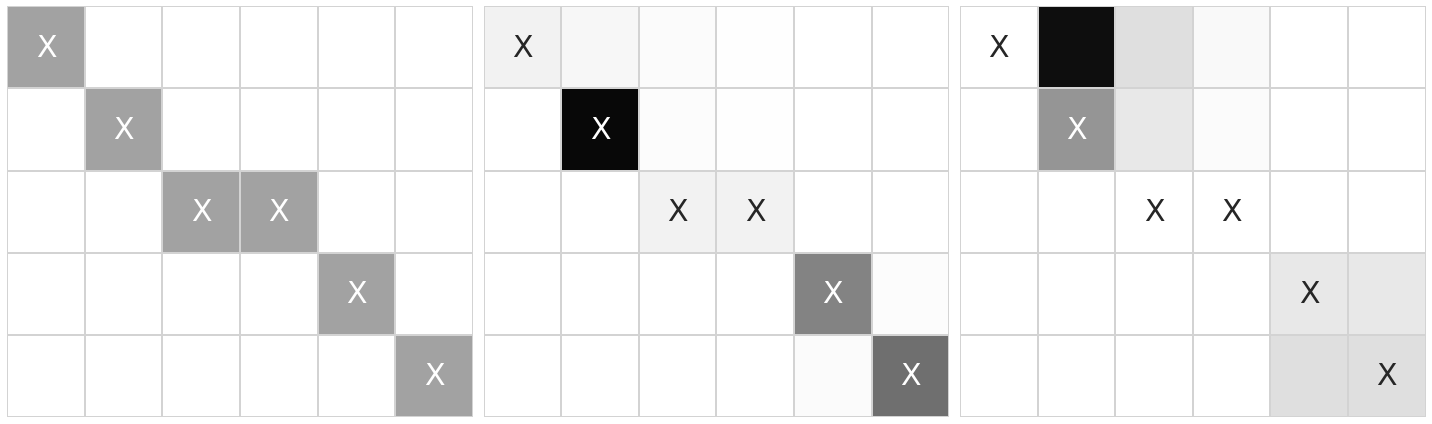

In [72]:
demo_bandit = (('red', 'circle'), ('red', 'triangle'), ('blue', 'square') )
demo_action_context = simulations.generate_context_from_actions(demo_bandit)

df = simulations.speakers_utterance_probabilities_single_action_context(demo_action_context, exp_1_speakers, exp_1_utterances, sb_rewards)

speakers = [belief_speaker.name + "_prob", combined_speaker.name + "_prob", relevance_speaker.name + "_prob"]
                                                               
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

for i, ax in enumerate(axs.flat): 

    cbar = (i == 2)
    heatmap_speaker_action_dataframe(df, speakers[i], vmax=.36, cmap='Greys', ax=ax, cbar=False)

plt.tight_layout()
plt.savefig('theoretical_heatmaps.pdf')

[]

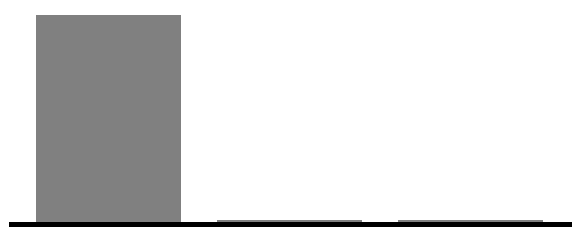

In [18]:
demo_listener = StatelessLiteralListener(beta=2, features=sb_all_features, possible_worlds=sb_worlds)
test_message = ('circle', 2)
policy = demo_listener.action_policy(test_message, demo_action_context).reset_index().listener_choice_prob

plt.figure(figsize=(10, 4))
plt.bar(x=policy.index, height=policy.values, color='gray')
plt.ylim(0, 1)
ax = plt.gca()
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.spines['left'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(5)


ax.set_xticks([])
ax.set_yticks([])
# ax.set_yticks([0, .5, 1])

# sns.barplot(x=policy.index, y=policy.values, c='k', alpha=.5)

In [19]:
## Plot MLEs from experimental data

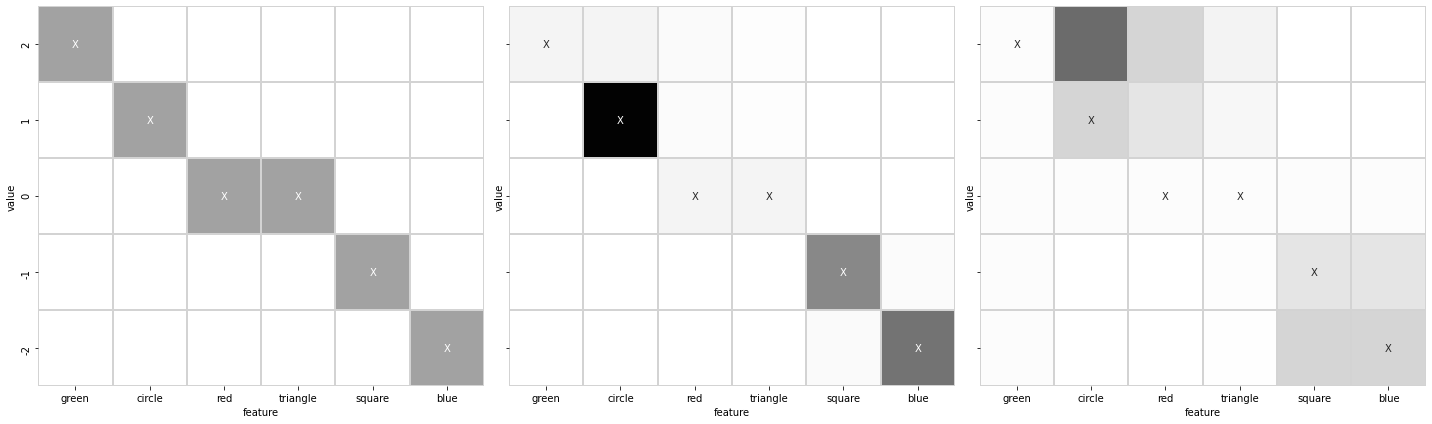

In [20]:
speakers = [unbiased_belief_mle.name + "_prob", unbiased_mle.name + "_prob", unbiased_action_mle.name + "_prob"]
                                                               
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

for i, ax in enumerate(axs.flat): 

    cbar = (i == 2)
    heatmap_speaker_action_dataframe(df, speakers[i], vmax=.36, cmap='Greys', ax=ax, cbar=False)

plt.tight_layout()
plt.savefig('mle_heatmaps.pdf')

### Average over all possible bandit configurations

In [21]:
exp_one_full_df = simulations.speaker_utterance_probabilities_multiple_action_contexts(sb_all_action_contexts, exp_1_speakers, exp_1_utterances, sb_rewards)

print("Evaluated over {} bandit configurations.".format(exp_one_full_df.action_context.nunique()))

Evaluated over 84 bandit configurations.


In [22]:
exp_one_local = simulations.summarize_speakers_performance(exp_one_full_df, speaker_list=exp_1_speakers)

exp_one_local[["speaker", "prob_truthful", "expected_rewards"]].groupby("speaker").mean()

,prob_truthful,expected_rewards
speaker,,
Action Only,0.392679,1.450152
Belief Only,1.000000,0.538652
Combined,0.899500,1.240921
MLE-action-bias-combined,0.662087,1.503027
MLE-belief-bias-combined,0.815614,0.715483
MLE-unbiased-action-only,0.374516,1.240033
MLE-unbiased-belief-only,1.000000,0.538652
MLE-unbiased-combined,0.872489,1.277911
MLE-unbiased-combined-valence,0.868196,1.336896


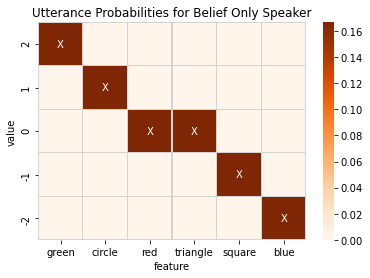

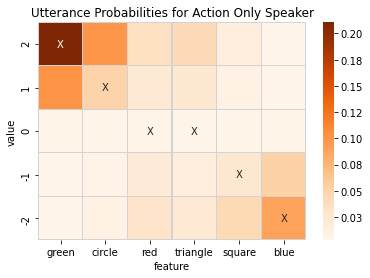

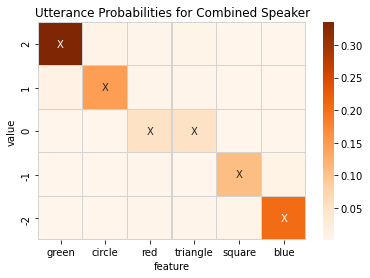

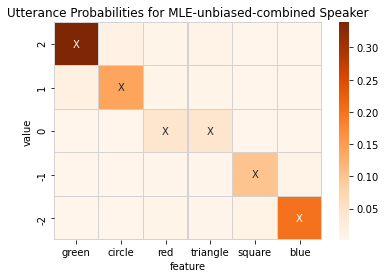

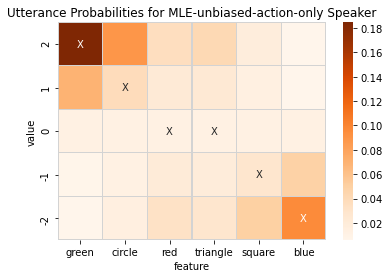

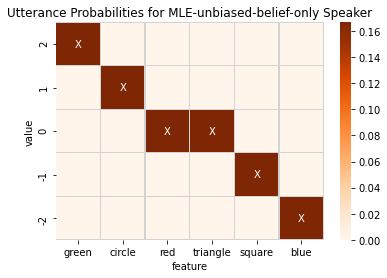

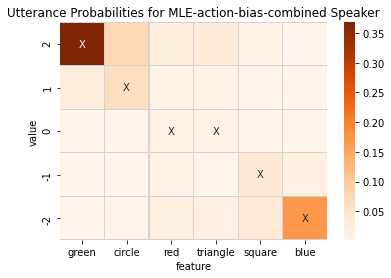

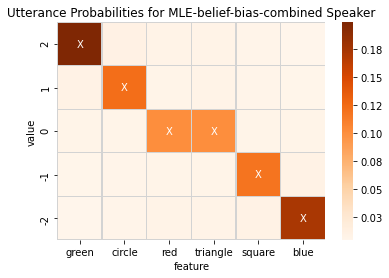

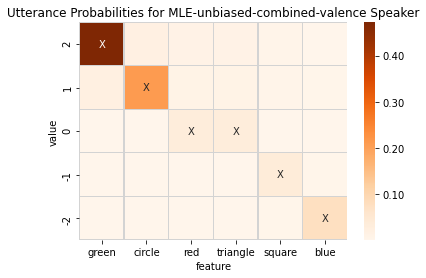

In [23]:
for s in exp_1_speakers:
    visualizations.heatmap_speaker_action_dataframe(exp_one_full_df, s, sb_rewards, cmap='Oranges')

## Generate Trials for Experiment

In [24]:
unique_contexts = exp_one_full_df.action_context.unique()
contexts = map(simulations.to_experiment_action_context_format, unique_contexts)

for_experiment = []
for c in contexts:
    for_experiment.append({
        "action_context":[c],
        "trial_type": "select"
    })

import random
random.shuffle(for_experiment)

split_one = for_experiment[:28]
split_two = for_experiment[28:56]
split_three = for_experiment[56:]

print("Split trials into sequences length {}, {}, {}.".format(len(split_one), len(split_two), len(split_three)))

# with open("../signaling-bandits-exp/static/json/exp1_split1.json", 'w') as outfile:
#     json.dump(split_one, outfile)
    
# with open("../signaling-bandits-exp/static/json/exp1_split2.json", 'w') as outfile:
#     json.dump(split_two, outfile)
    
# with open("../signaling-bandits-exp/static/json/exp1_split3.json", 'w') as outfile:
#     json.dump(split_three, outfile)

Split trials into sequences length 28, 28, 28.


## Export posterior predictives

In [25]:
exp_one_full_df.columns

Index(['utterance', 'feature', 'value', 'truthful', 'expected_rewards',
       'prob_optimal_action', 'Belief Only', 'Action Only', 'Combined',
       'MLE-unbiased-combined', 'MLE-unbiased-action-only',
       'MLE-unbiased-belief-only', 'MLE-action-bias-combined',
       'MLE-belief-bias-combined', 'MLE-unbiased-combined-valence',
       'Belief Only_prob', 'Action Only_prob', 'Combined_prob',
       'MLE-unbiased-combined_prob', 'MLE-unbiased-action-only_prob',
       'MLE-unbiased-belief-only_prob', 'MLE-action-bias-combined_prob',
       'MLE-belief-bias-combined_prob', 'MLE-unbiased-combined-valence_prob',
       'action_context', 'no_utterance_rewards'],
      dtype='object')

In [26]:
models = [s.name for s in speaker_list]

models_to_export = [p + "_prob" for p in models]

In [27]:
posterior_predictive_df = exp_one_full_df[models_to_export + ["action_context", "feature", "value"]]
posterior_predictive_df["action_context"] = posterior_predictive_df.action_context.apply(lambda x: json.dumps(simulations.to_experiment_action_context_format(x)))
posterior_predictive_df["feature"] = posterior_predictive_df.feature.apply(lambda x: simulations.sim_to_exp_stimulus[x])

posterior_predictive_df.head()

posterior_predictive_df.to_json("exp1_posterior_predictive_mle.json", orient='records')

/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_42687/1728293801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posterior_predictive_df["action_context"] = posterior_predictive_df.action_context.apply(lambda x: json.dumps(simulations.to_experiment_action_context_format(x)))
/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_42687/1728293801.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posterior_predictive_df["feature"] = posterior_predictive_df.feature.apply(lambda x: simulati

In [28]:
import re

def string_to_context_df(context_string):
    
    f = re.findall("|".join(sb_all_features), context_string)
    context_tuple = [(f[0], f[1]), (f[2], f[3]), (f[4], f[5])]

    return simulations.generate_context_from_actions(context_tuple)

def string_to_context_json(context_string):
    
    return string_to_context_df(context_string).to_json(orient='records')

# Experiment 2: "Loose Talk"

Here, we want to show that people follow **relevance** rather than **truthfulness**: they will lie in order to optimize decision making.

There are two possible varieties of this: using zero-value features (red/triangle) and seeing if people are willing to send non-zero messages; or (2) looking at low-magnitude features (square/circle) and seeing if they are willing to exaggerate.

1. Fix *feature* (e.g. red / triangle / square / circle)
2. Fix *value* (e.g. 2) and see if they'd rather be relevant (send "circle") or truthful (send "green") 

In [29]:
def generate_and_analyze_trials(feature, values, filter_relevant=True, listener_beta=3):
    
    exp_2_utterances = list(itertools.product([feature], values))
        
    listener_agent = StatelessLiteralListener(beta=listener_beta, features=sb_all_features, possible_worlds=sb_worlds)
    speaker_agent = CombinedSpeaker(listener=listener_agent, beta=0, w=sb_rewards, name="")
    exp2 = simulations.speaker_utterance_probabilities_multiple_action_contexts(sb_all_action_contexts, [speaker_agent], exp_2_utterances, sb_rewards)

    # Filter down to contexts which contain the target feature
    exp2["feature_occurence"] = exp2.action_context.apply(lambda x: len(re.findall(feature, x)))

    if filter_relevant:
        exp2 = exp2[exp2.feature_occurence > 0]
    
    # Round the reward differential so we only consider meaningful differences
    exp2["reward_diff"] = round(exp2.expected_rewards - exp2.no_utterance_rewards, 2)

    exp2["truthful_negative"] = ((exp2.truthful) & (exp2.reward_diff < 0))
    exp2["false_positive"] = ((~exp2.truthful) & (exp2.reward_diff > 0))

    exp2["objective_conflict"] = (exp2.truthful_negative | exp2.false_positive)
    exp2["rounded_reward_diff"] = myround(exp2.reward_diff)

    return exp2

def myround(x, prec=2, base=.25):
    
    return (base * (np.array(x) / base).round()).round(prec)
         
def generate_endorsement_trial(df_row):
    
    output = simulations.to_experiment_trial([df_row["action_context"]], 
                                             features=[df_row["feature"]], 
                                             values=[df_row["value"]],
                                             trial_type="slider")
    
    output["reward_diff"] = df_row["reward_diff"]
    output["expected_rewards"] = df_row["expected_rewards"]
    output["truthful"] = df_row["truthful"]
    output["no_utterance_rewards"] = df_row["no_utterance_rewards"]
    output["original_action_context"] = df_row["action_context"]
    
    return output
 
square_trials = generate_and_analyze_trials("square", [-1, +1])
circle_trials = generate_and_analyze_trials("circle", [-1, +1])

exp2_weak_features = pd.concat([square_trials, circle_trials])

triangle_trials = generate_and_analyze_trials("triangle", [-1, 0, +1])
red_trials = generate_and_analyze_trials("red", [-1, 0, +1])

exp2_neutral_features = pd.concat([triangle_trials, red_trials])

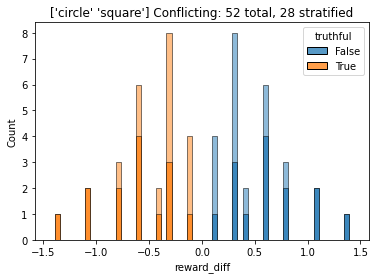

In [30]:
# multi_occurence = conflicted[conflicted.feature_occurence > 1]
# sns.histplot(multi_occurence, x='reward_diff', hue='truthful', multiple='dodge', bins=30)
# print(len(multi_occurence))

conflicted_weak = exp2_weak_features[exp2_weak_features.objective_conflict]

# TODO: DE-stratify here and use every utterance
sns.histplot(conflicted_weak, x='reward_diff', hue='truthful', multiple='dodge', bins=30, alpha=.5)

stratified_conflicted_weak = conflicted_weak.groupby(["feature", "reward_diff"]).sample(1)
sns.histplot(stratified_conflicted_weak, x='reward_diff', hue='truthful', multiple='dodge', bins=30)

plt.title("{} Conflicting: {} total, {} stratified".format(
    stratified_conflicted_weak.feature.unique(), 
    len(conflicted_weak), 
    len(stratified_conflicted_weak)));

red         28
triangle    16
Name: feature, dtype: int64

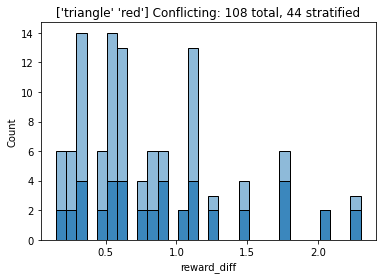

In [31]:
conflicted_neutral = exp2_neutral_features[exp2_neutral_features.objective_conflict]

stratified_conflicted_neutral = conflicted_neutral.groupby(["feature", "reward_diff", "value"]).sample(1)

sns.histplot(conflicted_neutral, x='reward_diff', multiple='dodge', bins=30, alpha=.5)
sns.histplot(stratified_conflicted_neutral, x='reward_diff',  multiple='dodge', bins=30)

plt.title("{} Conflicting: {} total, {} stratified".format(
    conflicted_neutral.feature.unique(), 
    len(conflicted_neutral),
    len(stratified_conflicted_neutral)));

stratified_conflicted_neutral.feature.value_counts()
# for i, r in conflicted_neutral.sample(3).iterrows():
#     visualizations.plot_color_string(r["action_context"], title="{}: {} --> {}".format(r["feature"], r["value"], r["reward_diff"]))

Example conflicted context / utterance pairs


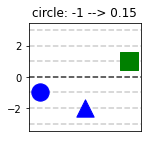

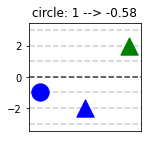

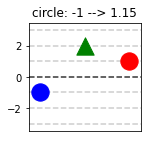

In [32]:
print("Example conflicted context / utterance pairs")
for i, r in stratified_conflicted_weak.sample(3).iterrows():
    visualizations.plot_color_string(r["action_context"], title="{}: {} --> {}".format(r["feature"], r["value"], r["reward_diff"]))

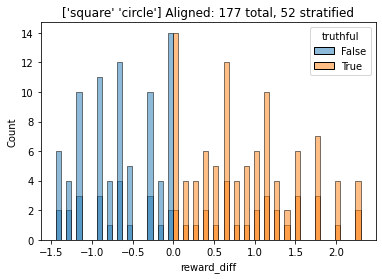

In [33]:
aligned_weak = exp2_weak_features[~exp2_weak_features.objective_conflict]

# TODO: allow these to range UP TO 2.2, DOWN TO -1.5 so that we have same range as "conflicting"
aligned_weak = aligned_weak[(aligned_weak.reward_diff <= 2.3) & (aligned_weak.reward_diff >= -1.44)]

stratified_aligned_weak = aligned_weak.groupby(["feature", "value", "reward_diff"]).sample(1)

sns.histplot(stratified_aligned_weak, x="reward_diff", hue="truthful", multiple='dodge', bins=30, alpha=.5)
sns.histplot(aligned_weak, x="reward_diff", hue="truthful", multiple='dodge', bins=30, alpha=.5)

plt.title("{} Aligned: {} total, {} stratified".format(
    aligned_weak.feature.unique(), 
    len(aligned_weak),
    len(stratified_aligned_weak)));

plt.show()

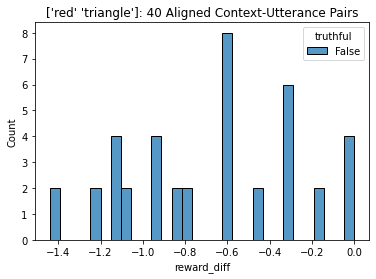

In [34]:
aligned_neutral = exp2_neutral_features[~exp2_neutral_features.objective_conflict]
aligned_neutral = aligned_neutral[~aligned_neutral.truthful]

aligned_neutral = aligned_neutral[aligned_neutral.reward_diff >= -1.44]
stratified_aligned_neutral = aligned_neutral.groupby(["feature", "reward_diff", "value"]).sample(1)

sns.histplot(stratified_aligned_neutral, x="reward_diff", hue="truthful", multiple='dodge', bins=30)
plt.title("{}: {} Aligned Context-Utterance Pairs".format(stratified_aligned_neutral.feature.unique(), len(stratified_aligned_neutral)));

plt.show()

<AxesSubplot:xlabel='reward_diff', ylabel='Count'>

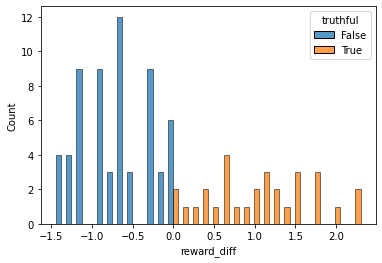

In [35]:
aligned = pd.concat([stratified_aligned_weak, stratified_aligned_neutral])
sns.histplot(aligned, x="reward_diff", hue="truthful", multiple='dodge', bins=30)

In [36]:
print(len(stratified_conflicted_weak))
print(len(stratified_conflicted_neutral))
print(len(aligned))

28
44
92


In [37]:
# 28 conflicting "weak"
# 44 conflicting "neutral"
# = 72

# 52 aligned "weak"
# 48 aligned "neutral"
# = 92 total --> sample to 72

conflicted_for_pilot = pd.concat([stratified_conflicted_weak.sort_values(["feature", "truthful", "reward_diff"]),
                                  stratified_conflicted_neutral.sort_values(["feature", "truthful", "reward_diff"])])

aligned_for_pilot = aligned.sample(len(conflicted_for_pilot)).sort_values(["feature", "truthful", "reward_diff"])

sample_for_pilot = pd.concat([aligned_for_pilot, conflicted_for_pilot])

print(len(sample_for_pilot[sample_for_pilot.truthful]))
print(sample_for_pilot.feature.value_counts())

41
red         49
square      37
circle      34
triangle    24
Name: feature, dtype: int64


In [38]:
sample_for_pilot["utility"] = sample_for_pilot.reward_diff.apply(lambda x: "pos" if x >= 0 else "neg")
sample_for_pilot["truth"] = sample_for_pilot.truthful.apply(lambda x: "true" if x else "false")

sample_for_pilot.groupby(["truth", "utility"]).size()

truth  utility
false  neg        42
       pos        61
true   neg        14
       pos        27
dtype: int64

(-2.5, 2.5)

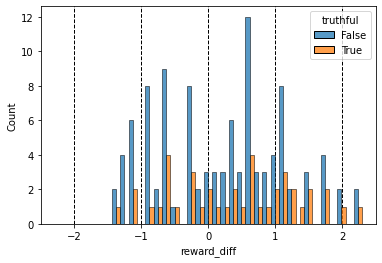

In [39]:
sns.histplot(sample_for_pilot, x='reward_diff', hue='truthful', multiple='dodge', bins=30)

for x in [-2, -1, 0, 1, 2]:
    plt.axvline(x, c='k', linewidth=1, linestyle='--', zorder=0)
plt.xlim(-2.5, 2.5)

In [40]:
sample_for_pilot.groupby("objective_conflict").size()

objective_conflict
False    72
True     72
dtype: int64

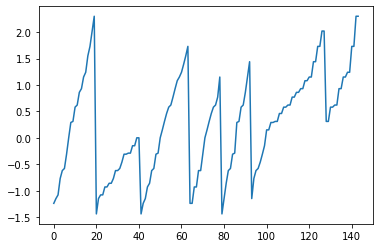

In [41]:
reindexed = sample_for_pilot.reset_index()
reindexed.reward_diff.plot()

n_splits = 4

# Generate three splits
splits = [[],[], [], []]
validation = [[],[],[], []]

for i, row in reindexed.iterrows():
    
    splits[i%n_splits].append(generate_endorsement_trial(row))
    validation[i%n_splits].append(row)

Text(0.5, 0, 'index')

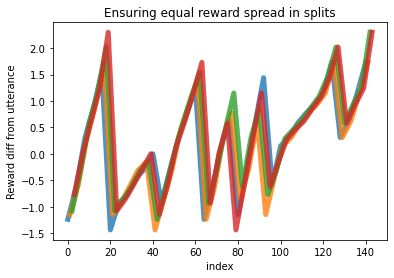

In [42]:
for v in validation:
    pd.DataFrame(v).reward_diff.plot(alpha=.8, linewidth=5)

plt.title("Ensuring equal reward spread in splits")
plt.ylabel("Reward diff from utterance")
plt.xlabel("index")

In [43]:
pd.DataFrame.from_dict(splits[0]).features.apply(lambda x: x[0]).value_counts()

Red        13
Spotted     9
Striped     8
Solid       6
Name: features, dtype: int64

In [44]:
pd.DataFrame.from_dict(splits[1]).features.apply(lambda x: x[0]).value_counts()

Red        12
Spotted     9
Striped     9
Solid       6
Name: features, dtype: int64

In [45]:
pd.DataFrame.from_dict(splits[2]).features.apply(lambda x: x[0]).value_counts()

Red        12
Striped    10
Spotted     8
Solid       6
Name: features, dtype: int64

In [46]:
for i, split in enumerate(splits):

    print("Split {}: {} trials.".format(i, len(split)))

#     with open("../signaling-bandits-exp/static/json/exp2_split{}.json".format(i+1), 'w') as outfile:
#         json.dump(split, outfile)

Split 0: 36 trials.
Split 1: 36 trials.
Split 2: 36 trials.
Split 3: 36 trials.


### Generate list of all possible Exp2+ trials
Used in experiment analysis.

In [47]:
all_exp2_trials = pd.concat([exp2_weak_features,exp2_neutral_features]).reset_index()

exp2_trials = all_exp2_trials.apply(lambda x: generate_endorsement_trial(x), axis=1)
exp2_trials = pd.DataFrame(list(exp2_trials))
exp2_trials.to_json("exp2_all_trials.json")

In [48]:
square_trials = generate_and_analyze_trials("square", [-1, +1], listener_beta=1)
circle_trials = generate_and_analyze_trials("circle", [-1, +1], listener_beta=1)
triangle_trials = generate_and_analyze_trials("triangle", [-1, 0, +1], listener_beta=1)
red_trials = generate_and_analyze_trials("red", [-1, 0, +1], listener_beta=1)

exp2_weak_listener = pd.concat([square_trials, circle_trials, triangle_trials, red_trials])

exp2_trials = exp2_weak_listener.apply(lambda x: generate_endorsement_trial(x), axis=1)
exp2_trials = pd.DataFrame(list(exp2_trials))

exp2_trials.to_json("exp2_all_trials_beta_one.json")

# Experiment 3: "Truthfulness Follows Relevance"

Here, we want to show that **truthfulness** follows **relevance**: uncertainty over decision context prevents people from simplifying.    

## Long-horizon cost of false utterances

In [49]:
square_exp3 = generate_and_analyze_trials("square", [-1, +1], filter_relevant=False)
circle_exp3 = generate_and_analyze_trials("circle", [-1, +1], filter_relevant=False)
red_exp3 = generate_and_analyze_trials("red", [-1, +1], filter_relevant=False)
triangle_exp3 = generate_and_analyze_trials("triangle", [-1, +1], filter_relevant=False)

exp3_all_features = pd.concat([square_exp3, circle_exp3, red_exp3, triangle_exp3])

In [50]:
exp3_all_features.groupby(["feature", "value"]).reward_diff.mean().round(5)

feature   value
circle    -1      -0.43345
           1       0.56250
red       -1       0.00000
           1      -0.00000
square    -1       0.43345
           1      -0.56250
triangle  -1       0.00000
           1      -0.00000
Name: reward_diff, dtype: float64

In [51]:
exp3_all_features.action_context.nunique()

84

# Miscellaneous

### Catch Trials

In [52]:
strong_true_pos_circle = [
    "['blue triangle' 'green circle' 'red square']",
    "['blue square' 'blue triangle' 'red circle']",
    "['blue triangle' 'green circle' 'green square']",
    "['blue square' 'green circle' 'red triangle']"]

strong_true_pos_square = [
    "['blue square' 'green circle' 'red square']",
    "['blue square' 'green square' 'green triangle']",
    "['blue square' 'red circle' 'red square']",
    "['blue square' 'green triangle' 'red circle']"]

### Validating WebPPL Models

,speaker,expected_rewards
0,Utility,0.968478


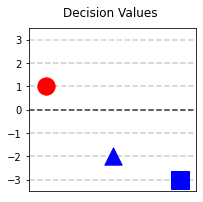

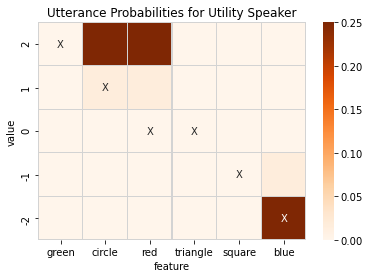

In [53]:
demo_bandit = (('red', 'circle'), ('blue', 'triangle'), ('blue', 'square'))
demo_action_context = simulations.generate_context_from_actions(demo_bandit)

# Define a listener
sb_listener = StatelessLiteralListener(beta=3, features=sb_all_features, possible_worlds=sb_worlds)
combined_speaker = CombinedSpeaker(sb_listener, beta=10, w=sb_rewards, name="Utility")

df = simulations.speakers_utterance_probabilities_single_action_context(demo_action_context, [combined_speaker], exp_1_utterances, sb_rewards)

visualizations.plot_action_df(demo_action_context)
visualizations.heatmap_speaker_action_dataframe(df, combined_speaker, sb_rewards, vmax=.25, cmap='Oranges')

simulations.summarize_speakers_performance(df, [combined_speaker])[["speaker", "expected_rewards"]]

In [54]:
df[["utterance", "Utility_prob"]].sort_values("Utility_prob", ascending=False)

,utterance,Utility_prob
2,"(blue, -2)",3.174770e-01
15,"(circle, 2)",3.174770e-01
10,"(red, 2)",3.174770e-01
18,"(circle, 1)",1.585630e-02
13,"(red, 1)",1.585630e-02
4,"(blue, -1)",1.585630e-02
22,"(square, -2)",1.119023e-07
24,"(square, -1)",6.288767e-08
27,"(triangle, -2)",7.681226e-10
29,"(triangle, -1)",6.099877e-10


## Simulation-Based Power Analysis

In [55]:
def simulation_row_to_webppl_input(row):
    
    action_context = simulations.to_experiment_action_context_format(row["action_context"])

    return {"action_context": action_context,
            "workerid": "simulated",
            "objective": "simulated-ambiguous-MLE",
            "response": {"feature": simulations.sim_to_exp_stimulus[row["feature"]], 
                         "feature_value": row["value"]}}

In [56]:
!ls "../signaling-bandits-exp/data/webppl-input/power-analysis"

ls: ../signaling-bandits-exp/data/webppl-input/power-analysis: No such file or directory


In [57]:
exp_one_full_df.head()

,utterance,feature,value,truthful,expected_rewards,prob_optimal_action,Belief Only,Action Only,Combined,MLE-unbiased-combined,...,Action Only_prob,Combined_prob,MLE-unbiased-combined_prob,MLE-unbiased-action-only_prob,MLE-unbiased-belief-only_prob,MLE-action-bias-combined_prob,MLE-belief-bias-combined_prob,MLE-unbiased-combined-valence_prob,action_context,no_utterance_rewards
0,"(blue, 2)",blue,2,False,-2.0,0.333333,-23.025851,-2.0,-1.5,-1.55,...,0.015605,0.004545,0.005550,0.025861,1.627604e-14,0.009188,0.008979,0.008471,['blue circle' 'blue square' 'blue triangle'],-2.0
1,"(blue, 0)",blue,0,False,-2.0,0.333333,-23.025851,-2.0,-1.5,-1.55,...,0.015605,0.004545,0.005550,0.025861,1.627604e-14,0.009188,0.008979,0.004001,['blue circle' 'blue square' 'blue triangle'],-2.0
2,"(blue, -2)",blue,-2,True,-2.0,0.333333,-8.047190,-2.0,-0.5,-0.65,...,0.015605,0.091281,0.082586,0.025861,1.666667e-01,0.030506,0.120887,0.028124,['blue circle' 'blue square' 'blue triangle'],-2.0
3,"(blue, 1)",blue,1,False,-2.0,0.333333,-23.025851,-2.0,-1.5,-1.55,...,0.015605,0.004545,0.005550,0.025861,1.627604e-14,0.009188,0.008979,0.008471,['blue circle' 'blue square' 'blue triangle'],-2.0
4,"(blue, -1)",blue,-1,False,-2.0,0.333333,-23.025851,-2.0,-1.5,-1.55,...,0.015605,0.004545,0.005550,0.025861,1.627604e-14,0.009188,0.008979,0.001890,['blue circle' 'blue square' 'blue triangle'],-2.0


In [58]:
N_PARTICIPANTS = 1
N_REPEATS = 1000

for i in range(0, N_REPEATS):
    all_dfs = []

    for context, utterances in exp_one_full_df.groupby("action_context"):
                
        # sample extra utterances to be safe MLE-Utility_prob
        simulated_utterances = utterances.sample(n=N_PARTICIPANTS, replace=True, weights="MLE-Ambiguous_prob")
        all_dfs.append(simulated_utterances)
    
    sampled_utterances = pd.concat(all_dfs)
    sampled_utterances = sampled_utterances.sample(N_PARTICIPANTS*36)
    
    if i % 100 == 0:
        print("Rep {}: {} utterances.".format(i, len(sampled_utterances)))
    
    formatted_for_webppl = list(sampled_utterances.apply(lambda x: simulation_row_to_webppl_input(x), axis=1))
    output_file = "../signaling-bandits-exp/data/webppl-input/power-analysis/{}-participants-run-{}.json".format(N_PARTICIPANTS, i)
    json.dump(formatted_for_webppl, open(output_file, 'w'))
    
sampled_utterances.head()

KeyError: 'String passed to weights not a valid column'

In [ ]:
sampled_utterances["truthful"].value_counts()

In [ ]:
percent_of_messages = (sampled_utterances.groupby(["feature", "value"]).size() / len(sampled_utterances)).reset_index()

message_table = percent_of_messages.pivot("value", "feature", 0)

features_in_descending_order = ["green", "circle", "triangle", "red", "square", "blue"]
message_table = message_table.reindex(features_in_descending_order, axis=1).fillna(0)

plt.figure()
ax = sns.heatmap(message_table, cmap="Oranges")#, annot=labels)
ax.invert_yaxis()


In [ ]:
print([{"action_context": [{"color": "Blue", "texture": "Striped"}, {"color": "Green", "texture": "Solid"}, {"color": "Red", "texture": "Solid"}], "workerid": "W00fd8c9c73", "objective": "ambiguous", "response": {"feature": "Green", "feature_value": 2}}])